In [1]:
rm(list = ls())
setwd('./')

library(Scissor)
library(tidydr)
library(Seurat)
library(dplyr)
library(ggplot2)
library(cols4all)
library(scales)
library(dplyr)
library(ggrepel)
library(scCustomize)
library(patchwork)
library(clusterProfiler)
library(org.Hs.eg.db)
library(tools)

Loading required package: Seurat

The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)

Attaching SeuratObject

Loading required package: Matrix


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


scCustomize v1.1.3
If you find the scCustomize useful please cite.
See 'samuel-marsh.github.io/scCustomize/articles/FAQ.html' for citation info.



Registered S3 methods overwritten by 'treeio':
  method              from    
  MRCA.p

In [2]:
# file_path <- "./data/raw/GSE132465_UMI_count_matrix.txt"
# molecules <- read.table(file_path, header = TRUE, row.names = 1, sep = "\t")
# save(molecules,file='./data/raw/GSE132465_UMI_count_matrix.Rdata')

load('./data/raw/GSE132465_UMI_count_matrix.Rdata')
dim(molecules)


[1] 33694 63689

In [3]:
anno <- read.table('./data/raw/GSE132465_GEO_processed_CRC_10X_cell_annotation.txt',header = TRUE, sep = "\t")

str_list <- anno$Index[anno$Cell_type=="Stromal cells"]
str_list <- gsub('-','.',str_list)

molecules_str <- molecules[, str_list]
sc_dataset <- Seurat_preprocessing(molecules_str, verbose = T)
dim(sc_dataset)
save(sc_dataset,file='./data/processed/str_scissor_sc_dataset.Rdata')

Centering and scaling data matrix

PC_ 1 
Positive:  COL1A2, LUM, RARRES2, DCN, C1R, COL3A1, COL1A1, FBLN1, SERPINF1, COL6A2 
	   PCOLCE, COL6A1, CTSK, NUPR1, SPON2, MEG3, TMEM176B, COL6A3, MFAP4, FTH1 
	   CLEC11A, AEBP1, SOD3, EMILIN1, VCAN, TMEM176A, LGALS1, CCDC80, MMP2, MXRA8 
Negative:  PECAM1, PLVAP, RAMP2, ECSCR.1, VWF, CD93, ADGRL4, RNASE1, RAMP3, CLEC14A 
	   ESAM, FLT1, CLDN5, PCAT19, CDH5, EGFL7, CYYR1, PODXL, ICAM2, MMRN2 
	   SRGN, PTPRB, NPDC1, FAM167B, CRIP2, TM4SF18, EMCN, TM4SF1, S1PR1, BCAM 
PC_ 2 
Positive:  IGHA1, JCHAIN, CFD, SEPP1, GSN, GPX3, ABCA8, LTBP4, ADH1B, IGHA2 
	   PLAC9, SOCS3, SCARA5, LSP1, ZFP36, ADAMDEC1, TCF21, LINC01082, MATN2, FXYD1 
	   TXNIP, SFRP1, PTN, CXCL12, CEBPD, MFAP4, KLF4, IGLC2, HAPLN1, CCL2 
Negative:  CTHRC1, BGN, INHBA, SPARC, COL5A2, THBS2, COL12A1, TPM4, FAP, SERPINH1 
	   SULF1, RAB31, COL11A1, GJB2, ADAM12, SLC16A3, MFAP2, LOXL2, TAGLN, COL10A1 
	   COL1A1, GAPDH, SPHK1, POSTN, CTSB, BMP1, MMP14, PRRX1, IGHG4, AP2S1 
PC_ 3 
Posi

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 5933
Number of edges: 186497

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9093
Number of communities: 14
Elapsed time: 0 seconds


Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
00:54:54 UMAP embedding parameters a = 0.9922 b = 1.112

00:54:54 Read 5933 rows and found 10 numeric columns

00:54:54 Using Annoy for neighbor search, n_neighbors = 30

00:54:54 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

00:54:55 Writing NN index file to temp file /tmp/RtmpapkjtD/file28c0324a852121

00:54:55 Searching Annoy index using 1 thread, search_k = 3000

00:54:56 Annoy recall = 100%

00:54:57 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors

[1] 8571 5933

[1] TRUE

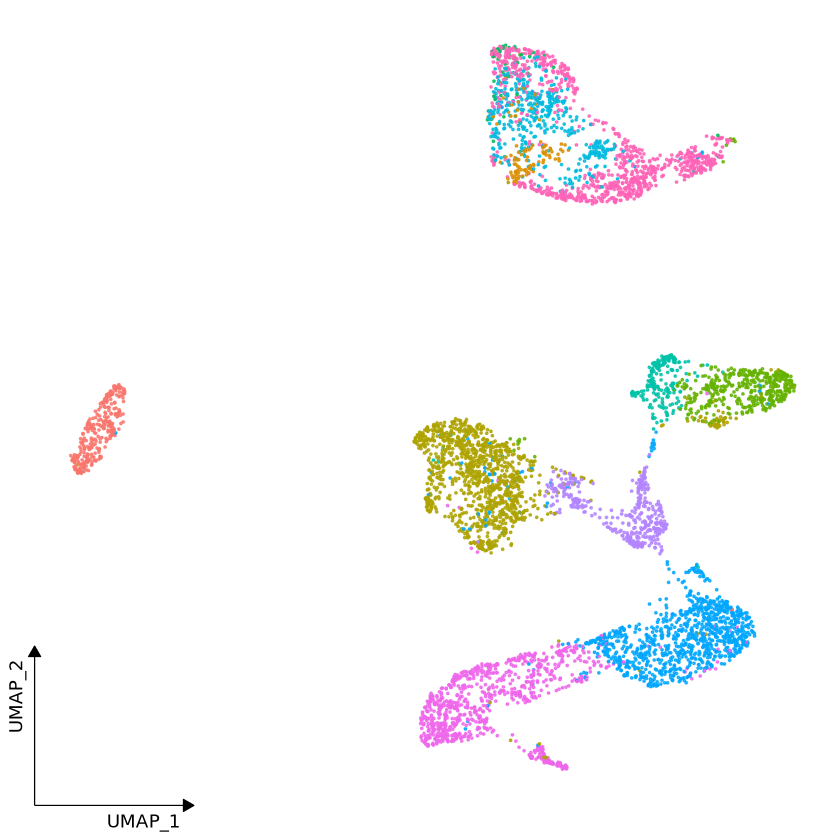

In [4]:
umap <- as.data.frame(sc_dataset@reductions$umap@cell.embeddings)
Cell_subtype <- anno[anno$Cell_type=="Stromal cells",]
Cell_subtype$Index <- gsub("\\-", ".", Cell_subtype$Index)

all(Cell_subtype$Index == colnames(sc_dataset))

sc_dataset <- AddMetaData(object = sc_dataset,
                          metadata = Cell_subtype$Cell_subtype,
                          col.name = "Cell_subtype")
cell_subtypes <- sc_dataset[["Cell_subtype"]]
umap <- cbind(umap,cell_subtypes)

mytheme <- theme_void() + 
  theme(plot.margin = margin(5.5,15,5.5,5.5)) 

p <- ggplot(data = umap, aes(x = UMAP_1, y = UMAP_2)) +
  geom_point(aes(color = Cell_subtype),
             size = 0.4,
             alpha = 0.8)
p1 <- p +
  theme_dr(xlength = 0.2, 
           ylength = 0.2,
           arrow = grid::arrow(length = unit(0.1, "inches"), 
                               ends = 'last', type = "closed"))
p2 <- p1 + theme(panel.grid = element_blank(),legend.position="none")
p2

In [5]:
load('./data/raw/crc_bulk_tpm.Rdata')
load('./data/raw/crc_bulk_survival.Rdata')

all(colnames(bulk_dataset_1) == bulk_survival$TCGA_patient_barcode)

phenotype <- data.frame(bulk_survival[,2:3])
colnames(phenotype) <- c("status","time")

infos1 <- Scissor(bulk_dataset_1, sc_dataset, phenotype, alpha = 0.0005, 
                 family = "cox", 
                 Save_file = './data/processed/stroma_scissor_CRC_survival.RData')
save(infos1,file='./data/processed/str_scissor_cells.Rdata')

[1] TRUE

[1] "|**************************************************|"
[1] "Performing quality-check for the correlations"
[1] "The five-number summary of correlations:"
        0%        25%        50%        75%       100% 
0.08181531 0.34590393 0.40094871 0.46875437 0.81047829 
[1] "|**************************************************|"
[1] "Perform cox regression on the given clinical outcomes:"
[1] "alpha = 5e-04"
[1] "Scissor identified 719 Scissor+ cells and 25 Scissor- cells."
[1] "The percentage of selected cell is: 12.540%"
[1] "|**************************************************|"


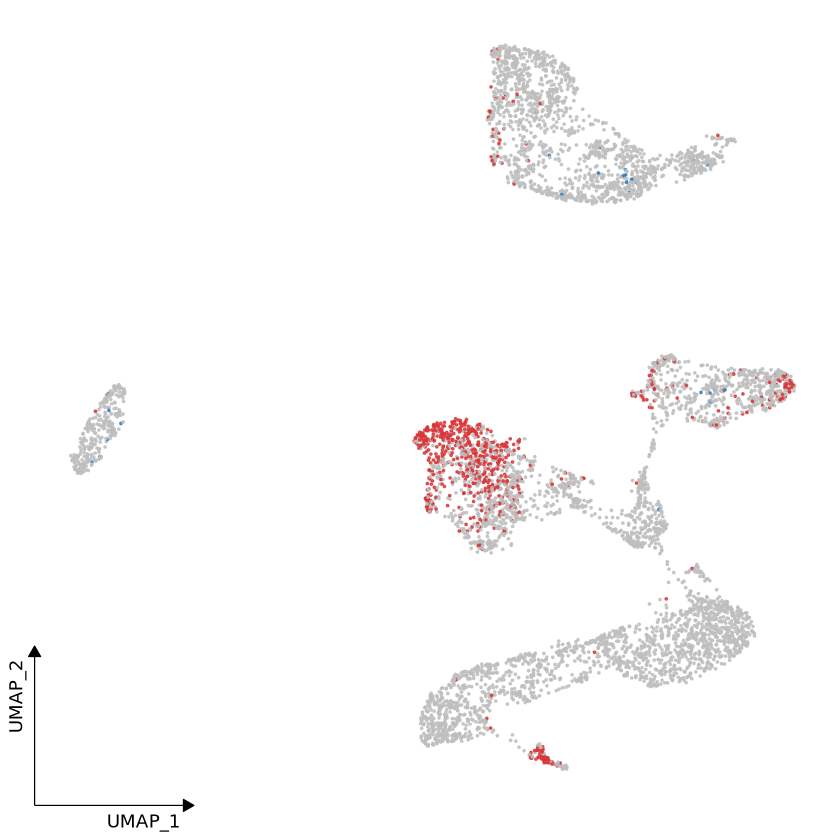

In [6]:
Scissor_select <- rep(0, ncol(sc_dataset))
names(Scissor_select) <- colnames(sc_dataset)
Scissor_select[infos1$Scissor_pos] <- 1
Scissor_select[infos1$Scissor_neg] <- 2                                    

sc_dataset <- AddMetaData(sc_dataset, metadata = Scissor_select, col.name = "scissor")
umap <- as.data.frame(sc_dataset@reductions$umap@cell.embeddings)

cell_subtypes <- sc_dataset[["scissor"]]
umap <- cbind(umap,cell_subtypes)

umap$scissor <- factor(umap$scissor,labels=c('Background cells',
                                              'Poor prognosis related cells',
                                              'Good prognosis related cells'))

mytheme <- theme_void() + 
  theme(plot.margin = margin(5.5,15,5.5,5.5)) 
my_colors <- c('grey', '#D8383A', '#2F7FC1')
p <- ggplot(data = umap, aes(x = UMAP_1, y = UMAP_2)) +
  geom_point(aes(color = scissor),
             size = 0.4,
             alpha = 0.8)+
  scale_color_manual(values = my_colors)
p1 <- p +
  theme_dr(xlength = 0.2, 
           ylength = 0.2,
           arrow = grid::arrow(length = unit(0.1, "inches"), 
                               ends = 'last', type = "closed"))
p2 <- p1 + theme(panel.grid = element_blank(),legend.position="none")
p2

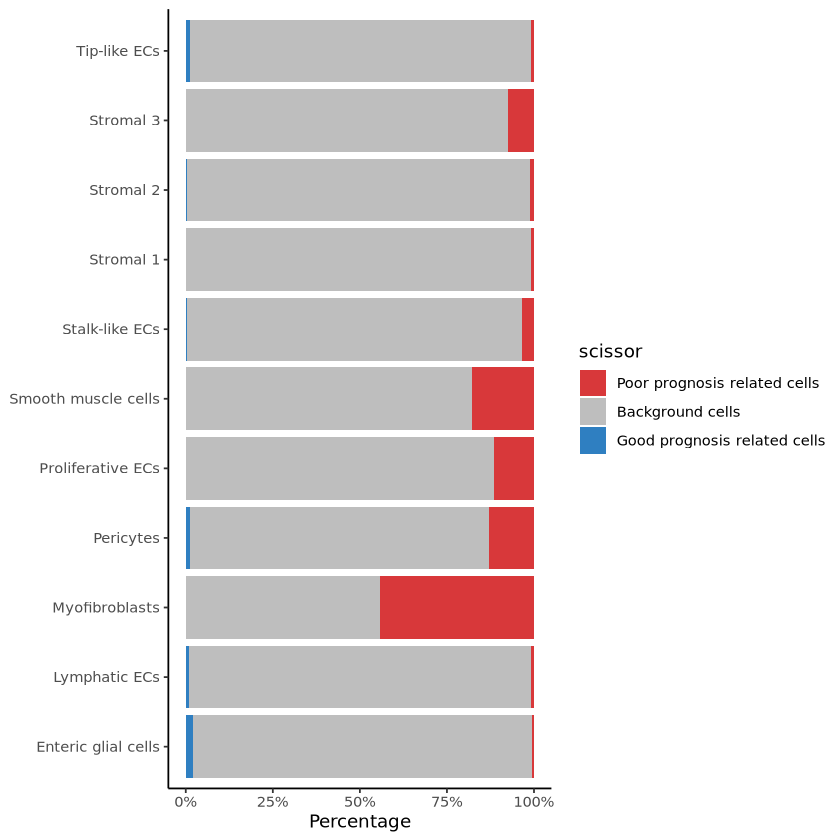

In [7]:
anno$Index <- gsub("\\-", ".", anno$Index)
merged_data <- merge(umap, anno, by.x = "row.names", by.y = "Index")
scissor_sub <- merged_data[c('scissor','Cell_subtype')]
scissor_sub <- scissor_sub %>%
  group_by(Cell_subtype) %>%
  count(scissor) %>%
  mutate(Percentage = n / sum(n))

scissor_sub$scissor <- factor(scissor_sub$scissor, levels = c('Poor prognosis related cells',
                                                              'Background cells',
                                                              'Good prognosis related cells'))

p1 <- ggplot(scissor_sub, aes(x = Percentage, y = Cell_subtype, fill = scissor)) +
  geom_bar(stat = "identity") +
  scale_x_continuous(labels = scales::percent_format(scale = 100)) +
  labs(x = "Percentage") +
  scale_fill_manual(values = c('#D8383A', 'grey', '#2F7FC1')) +
  theme_classic()+
  theme(axis.title.y = element_blank())
p1

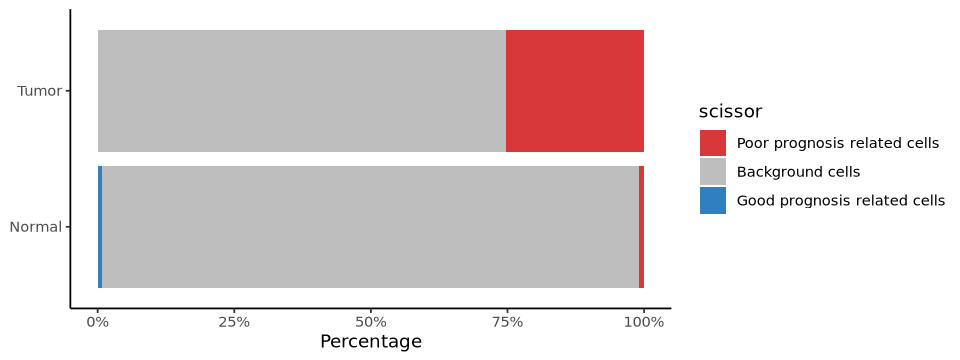

In [8]:
scissor_sub <- merged_data[c('scissor','Class')]
scissor_sub <- scissor_sub %>%
  group_by(Class) %>%
  count(scissor) %>%
  mutate(Percentage = n / sum(n))

scissor_sub$scissor <- factor(scissor_sub$scissor, levels = c('Poor prognosis related cells',
                                                              'Background cells',
                                                              'Good prognosis related cells'))

p1 <- ggplot(scissor_sub, aes(x = Percentage, y = Class, fill = scissor)) +
  geom_bar(stat = "identity") +
  scale_x_continuous(labels = scales::percent_format(scale = 100)) +
  labs(x = "Percentage") +
  scale_fill_manual(values = c('#D8383A', 'grey', '#2F7FC1')) +
  theme_classic()+
  theme(axis.title.y = element_blank())

options(repr.plot.width=8, repr.plot.height=3)
p1

In [9]:
degs <- FindMarkers(sc_dataset, ident.1 = '1', group.by = 'scissor')
save(degs,file='./data/processed/str_scissor_degs.Rdata')

degs$gene <- rownames(degs)
degs$v <- -log10(degs$p_val_adj)
degs$pct <- (degs$pct.1 - degs$pct.2)
degs$group <- ifelse((degs$p_val_adj < 0.05) & (degs$avg_log2FC > 1.5),'Up','Down/NS')

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


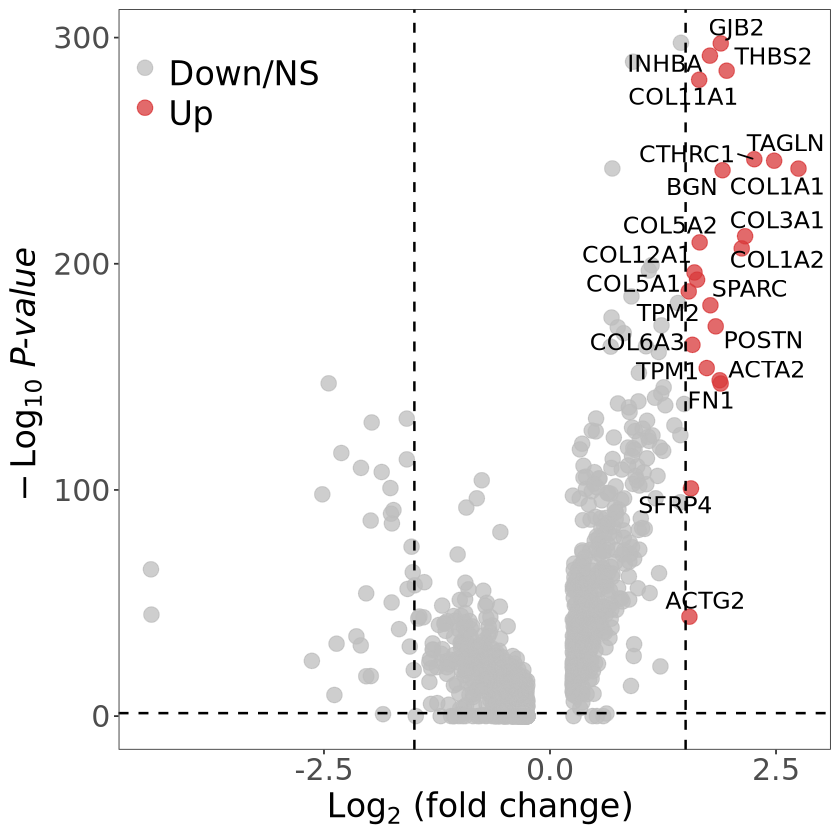

In [10]:
options(repr.plot.width=NULL, repr.plot.height=NULL)

mytheme <- theme_bw() + 
           theme(legend.key = element_rect(fill = 'transparent'), 
                 legend.background = element_rect(fill = 'transparent'), 
                 legend.position = c(0.15, 0.9),
                 legend.title = element_blank(),
                 legend.text = element_text(size = 20,margin = margin(t = 6)), 
                 axis.text.x = element_text(hjust = 0.5,size = 18), 
                 axis.text.y = element_text(size = 18), 
                 axis.title.x = element_text(size = 20), 
                 axis.title.y = element_text(size = 20), 
                #  axis.line = element_line(size = 1),
                 plot.title = element_text(size = 24, hjust = 0.5),
                 panel.grid = element_blank())
                 
volcano = ggplot(degs, aes(x=avg_log2FC, y=-log10(p_val_adj),color = group)) +
          geom_point(alpha = 0.75, size = 4) +
          labs(x = bquote(~Log[2]~"(fold change)"), 
               y = bquote(~-Log[10]~italic("P-value"))) +
          scale_colour_manual(name = "", values = alpha(c("gray","#D8383A"), 0.7)) + 
          geom_hline(yintercept = c(-log10(0.05)),size = 0.7,color = "black",lty = "dashed") + 
          geom_vline(xintercept = c(-1.5, 1.5),size = 0.7,color = "black",lty = "dashed") + 
          geom_text_repel(data = degs[degs$group=='Up',],
                      aes(x = avg_log2FC, y = -log10(p_val_adj), label = gene),
                      seed = 23456,color = 'black',size = 5,
                      show.legend = FALSE)+mytheme

volcano

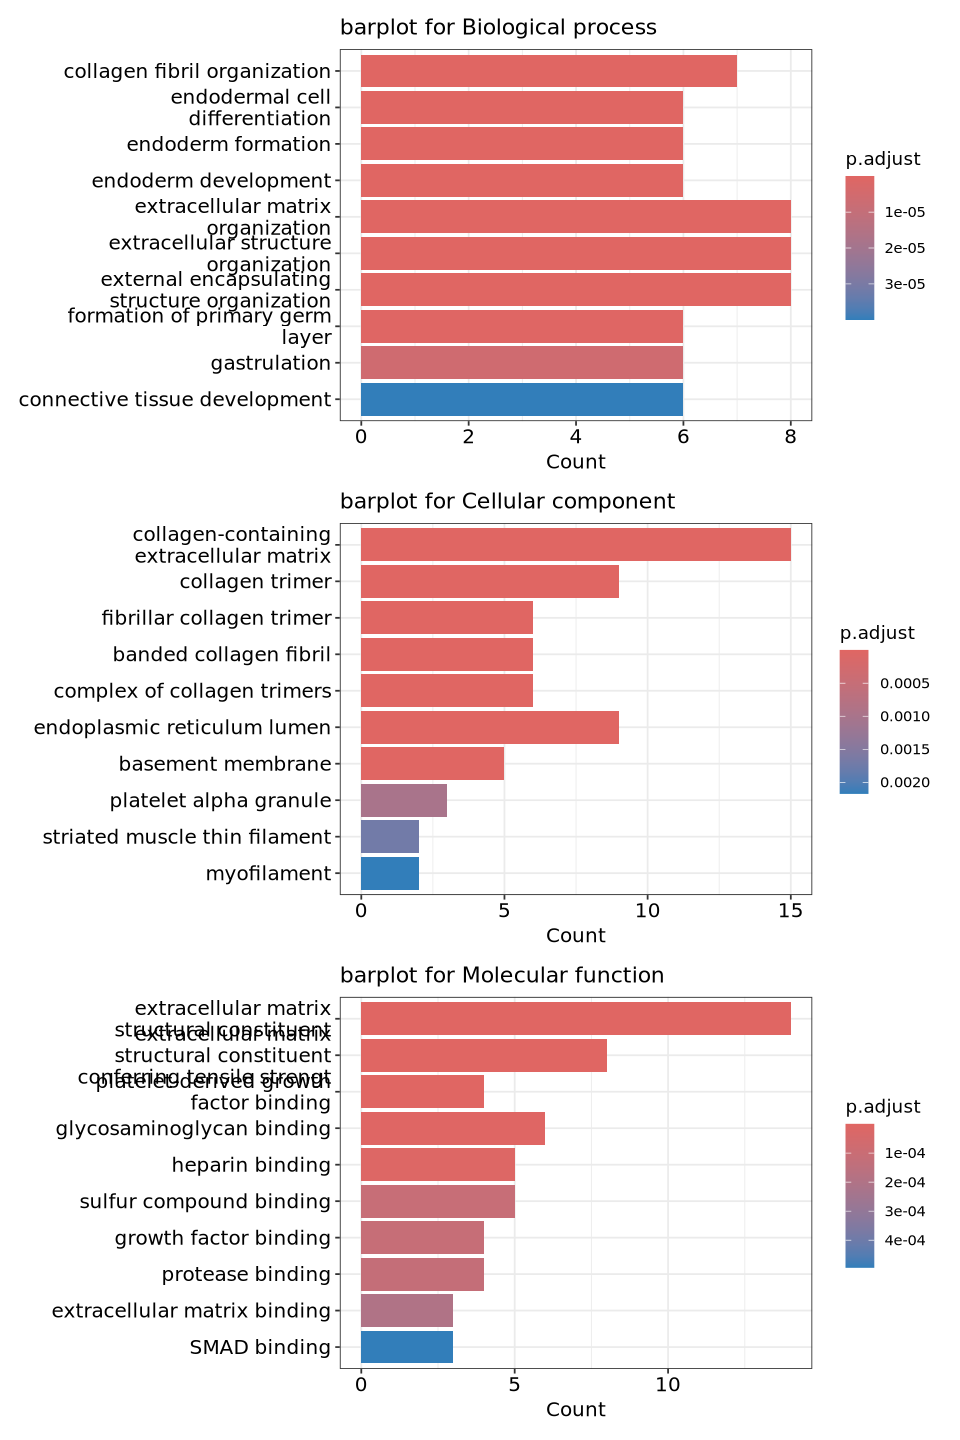

In [11]:
sig_degs <- subset(degs, p_val_adj < 0.05 & degs$avg_log2FC > 1.5)
sig_degs <- sig_degs[order(sig_degs$avg_log2FC,decreasing = T),]



ego_ALL <- enrichGO(gene          = rownames(sig_degs),
                   OrgDb         = 'org.Hs.eg.db',
                   keyType       = 'SYMBOL',
                   ont           = "ALL",
                   pAdjustMethod = "BH",
                   pvalueCutoff  = 0.01,
                   qvalueCutoff  = 0.05)
ego_all <- data.frame(ego_ALL)
       
ego_CC <- enrichGO(gene          = rownames(sig_degs),
                   #universe     = row.names(dge.celltype),
                   OrgDb         = 'org.Hs.eg.db',
                   keyType       = 'SYMBOL',
                   ont           = "CC",
                   pAdjustMethod = "BH",
                   pvalueCutoff  = 0.01,
                   qvalueCutoff  = 0.05)

ego_MF <- enrichGO(gene          = rownames(sig_degs),
                   #universe     = row.names(dge.celltype),
                   OrgDb         = 'org.Hs.eg.db',
                   keyType       = 'SYMBOL',
                   ont           = "MF",
                   pAdjustMethod = "BH",
                   pvalueCutoff  = 0.01,
                   qvalueCutoff  = 0.05)

ego_BP <- enrichGO(gene          = rownames(sig_degs),
                   #universe     = row.names(dge.celltype),
                   OrgDb         = 'org.Hs.eg.db',
                   keyType       = 'SYMBOL',
                   ont           = "BP",
                   pAdjustMethod = "BH",
                   pvalueCutoff  = 0.01,
                   qvalueCutoff  = 0.05)    

ego_CC@result$Description <- substring(ego_CC@result$Description,1,70)
ego_MF@result$Description <- substring(ego_MF@result$Description,1,70)
ego_BP@result$Description <- substring(ego_BP@result$Description,1,70)

p_BP <- barplot(ego_BP,showCategory = 10) + ggtitle("barplot for Biological process")
p_CC <- barplot(ego_CC,showCategory = 10) + ggtitle("barplot for Cellular component")
p_MF <- barplot(ego_MF,showCategory = 10) + ggtitle("barplot for Molecular function")

plotc <- p_BP/p_CC/p_MF

options(repr.plot.width=8, repr.plot.height=12)
plotc


Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minSize = minSize, :
“For some pathways, in reality P-values are less than 1e-10. You can set the `eps` argument to zero for better estimation.”


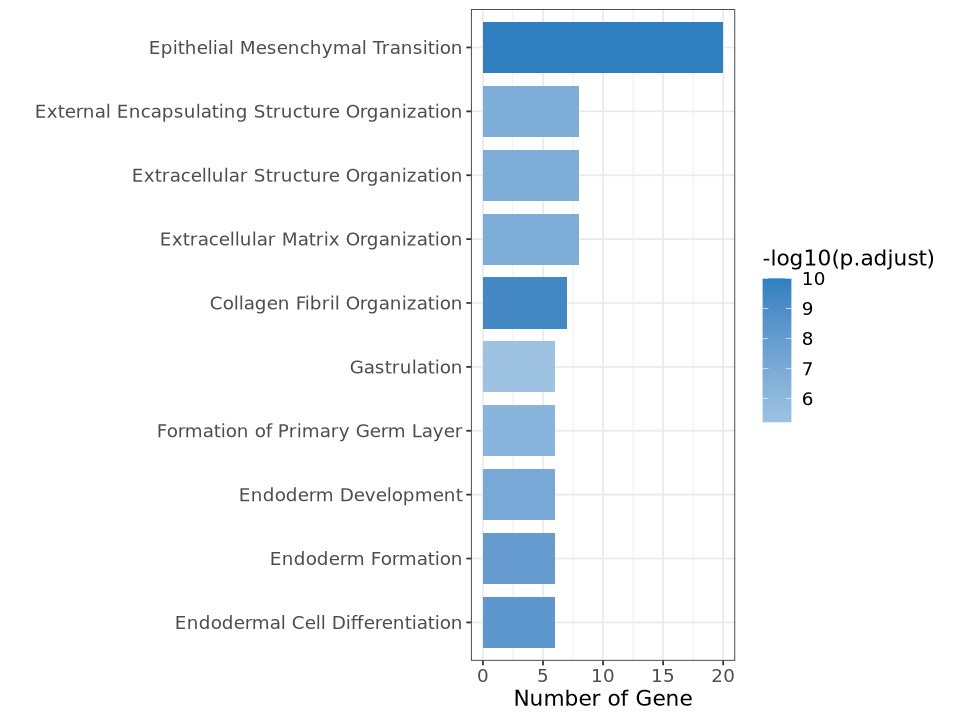

In [12]:
degs <- degs[order(degs$avg_log2FC,decreasing=T),]
gsea_input <- degs$avg_log2FC

sig_degs_1 <- subset(degs, p_val_adj < 0.05 & abs(degs$avg_log2FC) > 1.5)
sig_degs_1 <- sig_degs_1[order(sig_degs_1$avg_log2FC,decreasing=T),]
gsea_input <- sig_degs_1$avg_log2FC
names(gsea_input) <- rownames(sig_degs_1)

geneset <- read.gmt("./data/raw/h.all.v2022.1.Hs.symbols.gmt") 
 
gg <- GSEA(gsea_input, TERM2GENE=geneset,verbose=F,
           pvalueCutoff=0.1, pAdjustMethod = "BH")

sortgg<- gg[order(gg$NES, decreasing = T),]
sortgg<- sortgg[sortgg$p.adjust <0.05,]



enri_df <- ego_all[1:9,c('Description','p.adjust','Count')]
enri_df <- rbind(enri_df, data.frame(Description = "Epithelial mesenchymal transition", 
                                     p.adjust = sortgg$p.adjust ,
                                     Count = sortgg$setSize))
enri_df <- enri_df[order(enri_df$Count),]
enri_df$pathway <- factor(toTitleCase(enri_df$Description),levels=toTitleCase(enri_df$Description))

mytheme <- theme(
            axis.title = element_text(size = 13),
            axis.text = element_text(size = 11),
            plot.title = element_text(size = 14,
            hjust = 0.5,
            face = "bold"),
            legend.title = element_text(size = 13),
            legend.text = element_text(size = 11),
            plot.margin = margin(t = 5.5,
            r = 10,
            l = 5.5,
            b = 5.5)
            )

p <- ggplot(data = enri_df, aes(x = Count, y = pathway, fill = -log10(p.adjust))) +
       scale_fill_gradient2(low='#d9e8f4',mid="#8eb9dd",high="#2f7fc1",midpoint=6)+
       geom_bar(stat = "identity", width = 0.8) +
       labs(x = "Number of Gene", y = "") + 
       theme_bw() + mytheme 

options(repr.plot.width=8, repr.plot.height=6)
p


NOTE: FeaturePlot_scCustom uses a specified `na_cutoff` when plotting to
color cells with no expression as background color separate from color scale.
Please ensure `na_cutoff` value is appropriate for feature being plotted.
Default setting is appropriate for use when plotting from 'RNA' assay.
When `na_cutoff` not appropriate (e.g., module scores) set to NULL to
plot all cells in gradient color palette.

-----This message will be shown once per session.-----


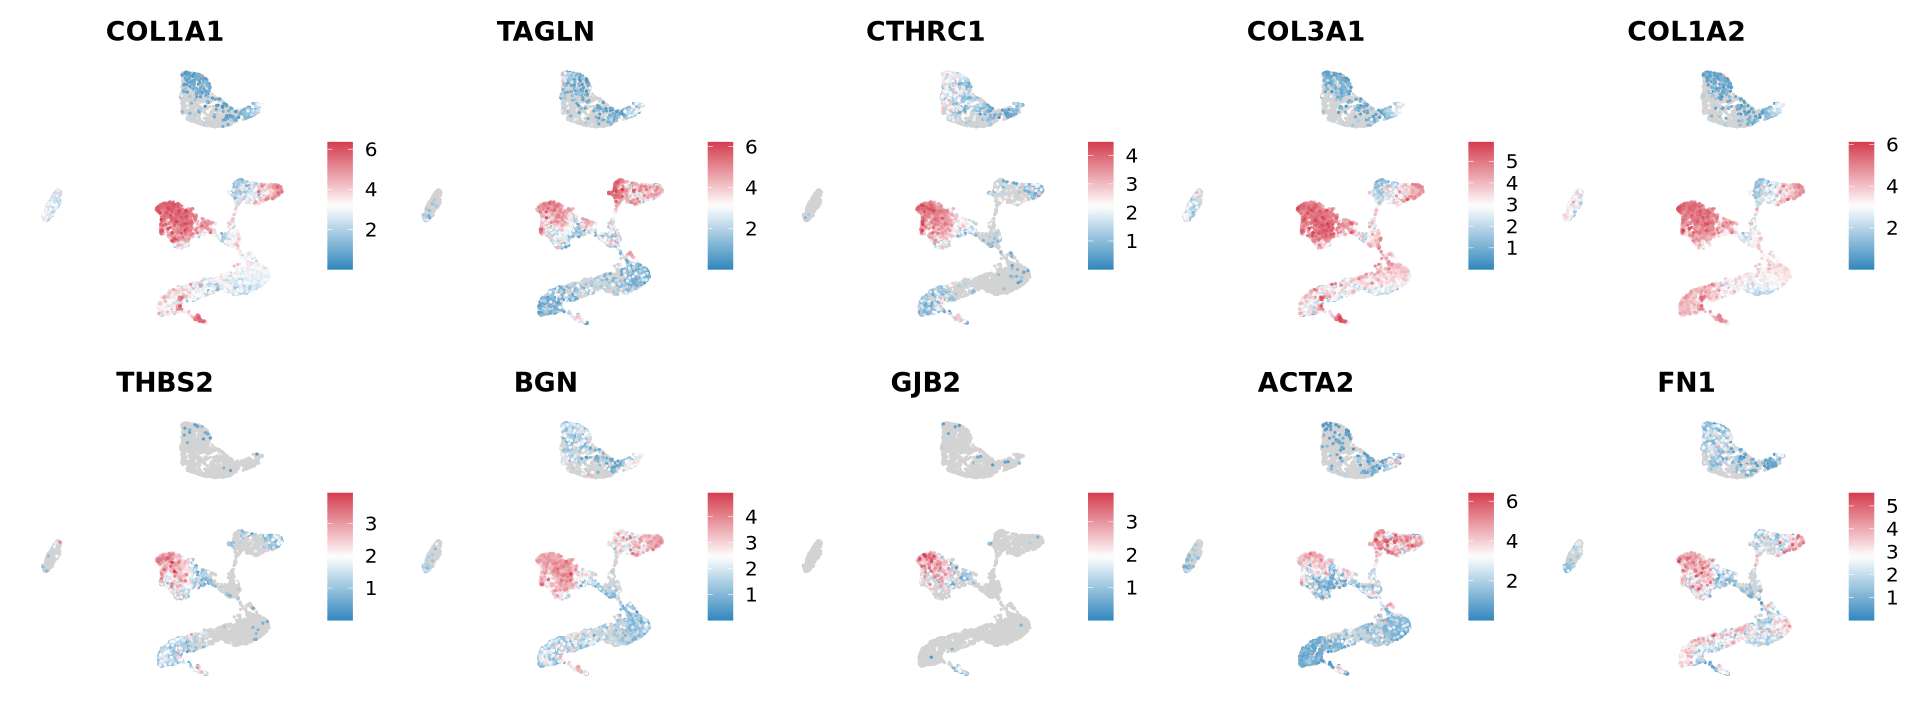

In [13]:
gene<-rownames(sig_degs)[1:10]
i=1
plots=list()
for (i in 1:length(gene)){
  plots[[i]]=FeaturePlot_scCustom(seurat_object = sc_dataset, 
                                  colors_use = colorRampPalette(c("#3288BD", "white", "#D53E4F" ))(50), 
                                  features = gene[i])+NoAxes()
}

p<-wrap_plots(plots, ncol = 5)
options(repr.plot.width=16, repr.plot.height=6)
p

In [17]:
sessionInfo()

R version 4.3.3 (2024-02-29)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Debian GNU/Linux 12 (bookworm)

Matrix products: default
BLAS/LAPACK: /anaconda3/envs/scCRC/lib/libopenblasp-r0.3.24.so;  LAPACK version 3.11.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: Europe/Berlin
tzcode source: system (glibc)

attached base packages:
[1] tools     stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] preprocessCore_1.62.1 org.Hs.eg.db_3.17.0   AnnotationDbi_1.64.1 
 [4] IRanges_2.34.1        S4Vectors_0.38.2      Biobase_2.60.0       
 [7] BiocGenerics_0.46.0   clusterProfiler_4.8.3 patchwork_1